# Advanced Lane Finding

In [1]:
# Pipeline
# 1 - calibrate camera
# 2 - distortion correction
# 3 - color and gradient threshold
# 4 - perspective transform
# 5 - locate lines (1 - with histogram, 2 - with convolution)
# 6 - measure curvature

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
#%matplotlib qt

In [3]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        # average x values of the fitted line over the last n iterations
        self.bestx = None     
        # polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        # polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        # radius of curvature of the line in some units
        self.radius_of_curvature = None 
        # distance in meters of vehicle center from the line
        self.line_base_pos = None 
        # difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        # x values for detected line pixels
        self.allx = None  
        # y values for detected line pixels
        self.ally = None

In [4]:
def calibrate_camera():
    """
    Calibrate camera with chess board.
    
    Input files were provided and are stored in ./camera_cal/*
    
    Ref.:
    [1] https://docs.opencv.org/3.0-beta/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html#findChessboardCorners
    [2] https://docs.opencv.org/3.0-beta/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html#drawchessboardcorners
    [3] http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_calibration/py_calibration.html
    [4] https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_calib3d/py_calibration/py_calibration.html
    """
    w = 9
    h = 6
    
    # termination criteria
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((h*w, 3), np.float32)
    objp[:, :2] = np.mgrid[0:w, 0:h].T.reshape(-1, 2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images (there are 20)
    images = glob.glob('./camera_cal/calibration*.jpg')
    
    cmtrx = np.zeros((3, 3))
    cdist = np.zeros((1, 5))
    n = len(images)

    # Step through the list and search for chessboard corners
    for fname in images:
        
        # cv2 read images in BGR color space
        img0 = cv2.imread(fname)
        
        # grayscale
        gray = cv2.cvtColor(img0, cv2.COLOR_BGR2GRAY)
        shape = gray.shape[::-1]

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (w, h), None)

        # If found, add object points, image points
        if ret == True:
            
            # objpoints are the original "perfect" points in the grid
            objpoints.append(objp)
            
            # increase accuracy
            cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
            
            # imgpoints are the same points in the distorted image
            imgpoints.append(corners)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img0, (w, h), corners, ret)
        else:
            print("Nothing found for: " + fname, ret)
    
    # 
    # The for-loop builds the arrays 'objpoints' and 'imgpoints'
    # that are used here to estimate camera coefficients
    #        
    # ret   - True/False
    # mtx   - camera matrix
    # dist  - distortion coefficients
    # rvecs - rotation vectors
    # tvecs - translation vectors
    # 
    r, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, shape, None, None)
    #h0, w0 = img.shape[:2]
    #newmtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w0, h0), 1, (w0, h0))
    return mtx, dist


In [5]:
mtx, dist = calibrate_camera()

Nothing found for: ./camera_cal/calibration5.jpg False
Nothing found for: ./camera_cal/calibration4.jpg False
Nothing found for: ./camera_cal/calibration1.jpg False


In [6]:
def remove_distortion(img):
    return cv2.undistort(img, mtx, dist, None, mtx)


In [7]:
def apply_threshold(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    """Apply color and Sobel_x (gradient) threshold
    
    Input image is assumed to be RGB.
    It is used the HLS color space and the threshold is applied to the S channel.
    """

    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Sobel x, Take the derivative in x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0)
    
    # Absolute x derivative to accentuate lines away from horizontal
    abs_sobelx = np.absolute(sobelx) 
    
    # scale abs_sobelx to the range 0 <=> 255
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold gradient_x
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    # 
    # np.zeros_like creates an "image" (actually an rectangular array) with zeros 
    # zero values are seen as black pixels
    # 
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    return color_binary


In [8]:
def perspective_transform():
    """Perspective transform
    
    Refs.:
    [1] https://discussions.udacity.com/t/perspective-transform/235255/23
    """
    src = np.float32([[(200, 720), (570, 470), (720, 470), (1130, 720)]])
    dst = np.float32([[(350, 720), (350,   0), (980,   0), ( 980, 720)]])
    return cv2.getPerspectiveTransform(src, dst)
    #Compute the inverse perspective transform:
    #Minv = cv2.getPerspectiveTransform(dst, src)
    #Warp an image using the perspective transform, M:
    #warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

M = perspective_transform()

In [21]:
def camera_top_view(img):
    return cv2.warpPerspective(img, M, img.shape[1::-1], flags=cv2.INTER_LINEAR)

In [35]:


def poly_fit(binary_warped):
    # starting point
    left_fit = np.array([0, 0, 0])
    right_fit = np.array([0, 0, 0])
    
    while 1:

        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0] // 2:,:], axis=0)

        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Choose the number of sliding windows
        nwindows = 9

        # Set height of windows
        window_height = np.int(binary_warped.shape[0] / nwindows)

        # Identify the x and y positions of all nonzero pixels in the image
        #
        # np.nonzero returns two arrays, first with axis=0 (Y) indices
        #   second with axis=1, (X) indices
        # 
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        # Current positions to be updated for each window (copy)
        leftx_current = leftx_base
        rightx_current = rightx_base

        # Set the width of the windows +/- margin
        margin = 100

        # Set minimum number of pixels found to recenter window
        minpix = 50

        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):

            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height

            # left line
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin

            # right line
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin


            # left line
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]

            # right line
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

            y = (win_y_high - win_y_low) / 2

            # first image will NOT use polyfit
            if np.sum(left_fit) > 0:

                # select a new stripe and search for peaks in histogram
                stripe = np.sum(binary_warped[win_y_low:win_y_high, :], axis=0)
                midpoint = np.int(stripe.shape[0] / 2)
                #leftx_base = np.argmax(stripe[:midpoint])
                #rightx_base = np.argmax(stripe[midpoint:]) + midpoint

                if len(good_left_inds) > minpix:
                    leftx_current = left_fit[0] * y**2 + left_fit[1]*y + left_fit[2]
                else:
                    #leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
                    leftx_current = np.argmax(stripe[:midpoint])

                if len(good_right_inds) > minpix:        
                    rightx_current = right_fit[0] * y**2 + right_fit[1]*y + right_fit[2]   
                else:
                    #rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
                    rightx_current = np.argmax(stripe[midpoint:]) + midpoint
            else:
                if len(good_left_inds) > minpix:
                    leftx_current = np.int(np.mean(nonzerox[good_left_inds]))

                if len(good_right_inds) > minpix:        
                    rightx_current = np.int(np.mean(nonzerox[good_right_inds]))


        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 
        
        if len(leftx) == 0 or leftx.size == 0:
            print('Trouble leftx?')
            print(leftx.shape)
            print(leftx.size)
            print(leftx)
        
        if len(lefty) == 0 or lefty.size == 0:
            print('Trouble lefty?')
            print(lefty.shape)
            print(lefty.size)
            print(lefty)
            
        if len(rightx) == 0 or rightx.size == 0:
            print('Trouble rightx?')
            print(rightx.shape)
            print(rightx.size)
            print(rightx)
            
        if len(righty) == 0 or righty.size == 0:
            print('Trouble righty?')
            print(righty.shape)
            print(righty.size)
            print(righty)

        # Fit a second order polynomial to each
        # 
        # np.polyfit (2) returns: coefficients A, B, C for x = Ayˆ2 + By + C
        #  as the we have a function of y, not x.
        # 
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)

        # =========
        # PLOT
        # =========

        if False:
            # Generate x and y values for plotting
            ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
            left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
            right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]

            # Create an image to draw on and an image to show the selection window
            out_img = np.dstack((binary_warped, binary_warped, binary_warped)) * 255
            window_img = np.zeros_like(out_img)

            # Color in left and right line pixels
            out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
            out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

            # Generate a polygon to illustrate the search window area
            # And recast the x and y points into usable format for cv2.fillPoly()
            left_line_window1 = np.array([np.transpose(np.vstack([left_fitx - margin, ploty]))])
            left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx + margin, 
                                          ploty])))])
            left_line_pts = np.hstack((left_line_window1, left_line_window2))
            right_line_window1 = np.array([np.transpose(np.vstack([right_fitx - margin, ploty]))])
            right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx + margin, 
                                          ploty])))])
            right_line_pts = np.hstack((right_line_window1, right_line_window2))

            # Draw the lane onto the warped blank image
            cv2.fillPoly(window_img, np.int_([left_line_pts]), (0, 255, 0))
            cv2.fillPoly(window_img, np.int_([right_line_pts]), (0, 255, 0))
            result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
            plt.imshow(result)
            plt.plot(left_fitx, ploty, color='yellow')
            plt.plot(right_fitx, ploty, color='yellow')
            plt.xlim(0, 1280)
            plt.ylim(720, 0)


        yield left_fit, right_fit

In [12]:
def calc_curvature(fit, y):
    return (1 + (2*fit[0]*y + fit[1])**2)**1.5 / np.absolute(2 * fit[0])


In [44]:
def pipeline(frame):
    
    frame = remove_distortion(frame)
    plt.figure()
    plt.imshow(frame)
    plt.title('distortion removed')
    
    frame = apply_threshold(frame)
    plt.figure()
    plt.imshow(frame)
    plt.title('threshold')
    
    warped = camera_top_view(frame)
    plt.figure()
    plt.imshow(warped)
    plt.title('warped')
    
    leftfit, rightfit = poly_fit(warped)
    
    r1 = calc_curvature(leftfit, warped.shape[0])
    r2 = calc_curvature(rightfit, warped.shape[0])
    
    print('Curvature: {: 7.3f}, car offset: {:7.3f}'.format((r1+r2)/2, 0))

# Exec

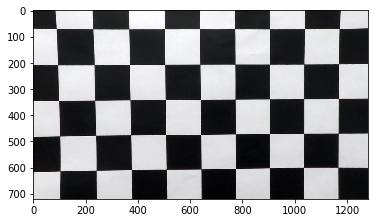

In [16]:
plt.figure()
plt.imshow(cv2.undistort(cv2.imread("./camera_cal/calibration1.jpg"), mtx, dist, None, mtx))

Checking ./test_images/test6.jpg
Trouble rightx?
(0,)
0
[]
Trouble righty?
(0,)
0
[]
expected non-empty vector for x
Checking ./test_images/test5.jpg
Trouble rightx?
(0,)
0
[]
Trouble righty?
(0,)
0
[]
expected non-empty vector for x
Checking ./test_images/test4.jpg
Trouble rightx?
(0,)
0
[]
Trouble righty?
(0,)
0
[]
expected non-empty vector for x
Checking ./test_images/test1.jpg
too many values to unpack (expected 2)
Checking ./test_images/test3.jpg
Trouble rightx?
(0,)
0
[]
Trouble righty?
(0,)
0
[]
expected non-empty vector for x
Checking ./test_images/test2.jpg
Trouble leftx?
(0,)
0
[]
Trouble lefty?
(0,)
0
[]
Trouble rightx?
(0,)
0
[]
Trouble righty?
(0,)
0
[]
expected non-empty vector for x
Checking ./test_images/straight_lines2.jpg


/Users/bgcarvalho/local/miniconda3/envs/ANN/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Trouble rightx?
(0,)
0
[]
Trouble righty?
(0,)
0
[]
expected non-empty vector for x
Checking ./test_images/straight_lines1.jpg
Trouble rightx?
(0,)
0
[]
Trouble righty?
(0,)
0
[]
expected non-empty vector for x


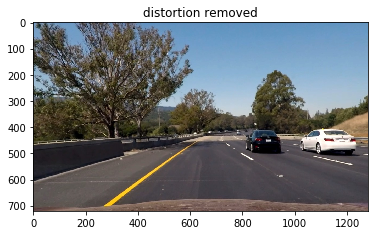

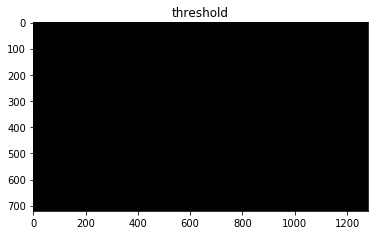

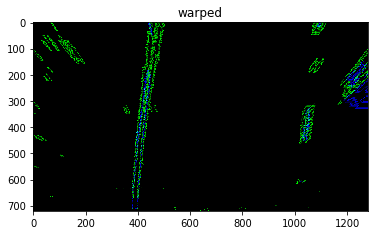

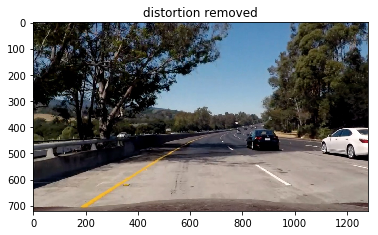

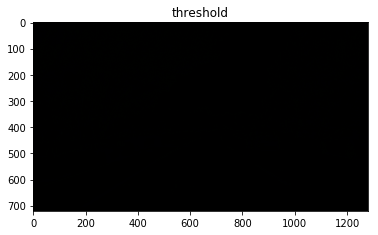

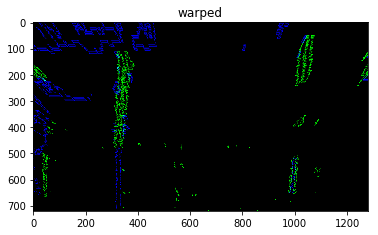

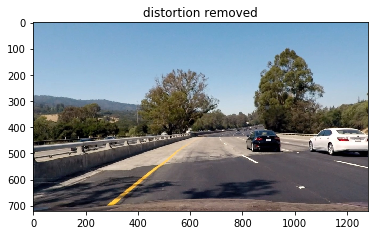

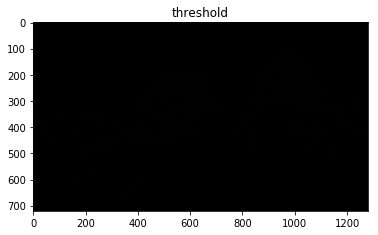

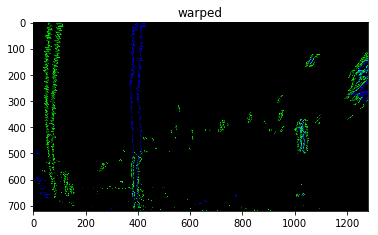

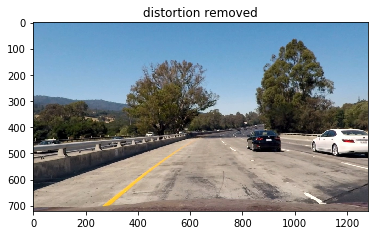

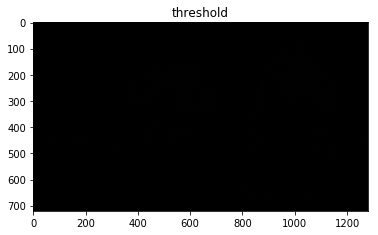

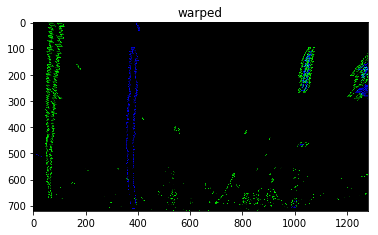

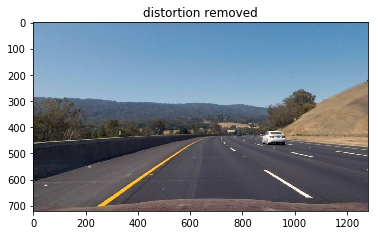

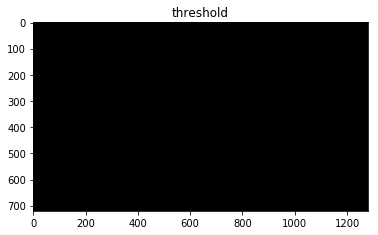

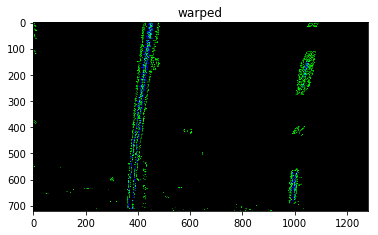

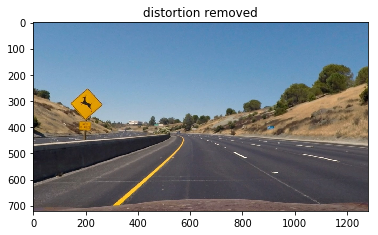

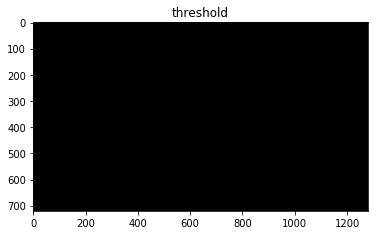

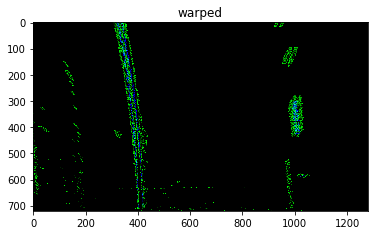

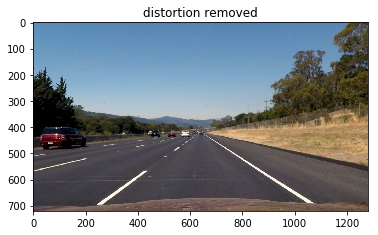

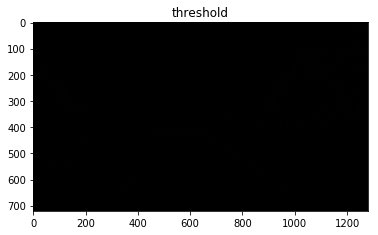

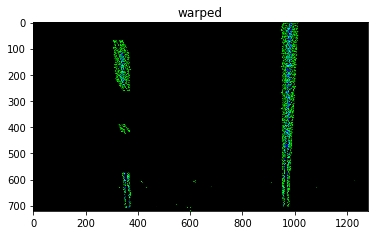

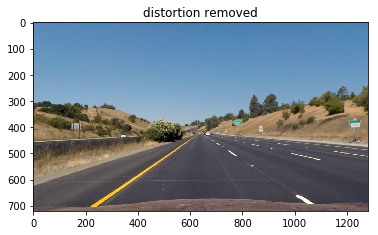

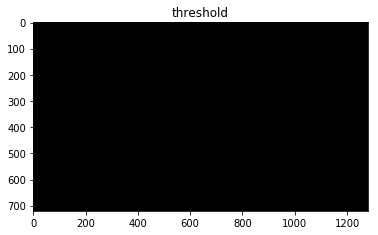

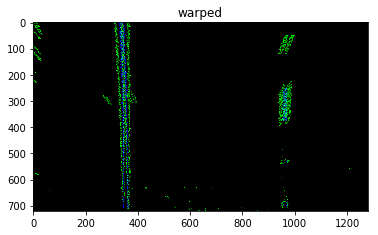

In [45]:
images = glob.glob('./test_images/*.jpg')

for fname in images:
    print('Checking ' + fname)
    print('=' * 40)
    
    #img = cv2.imread(fname)
    img = plt.imread(fname)
    
    try:
        pipeline(img)
    except ValueError as e:
        print(e)
    except TypeError as e:
        print(e)
    
    #plt.figure()
    #plt.imshow(img)
    
